In [1]:
import nltk
import numpy as np
import pandas as pd

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## The objective of this analysis is to find a model which will properly classify the statement as ironic or not. I'll use the data from here: https://www.kaggle.com/rtatman/ironic-corpus/home. The data contains 1950 comments, which have been labeled as ironic (1) or not ironic (-1) by human annotators. The text was taken from Reddit comments.

# Data load, basic preparation

In [3]:
data = pd.read_csv("irony-labeled.csv",escapechar="$")

In [4]:
data.head()

,comment_text,label
0,I suspect atheists are projecting their desire...,-1
1,It's funny how the arguments the shills are ma...,-1
2,We are truly following the patterns of how the...,-1
3,air pressure dropping as altitude goes higher....,-1
4,Absolutely. I think we'd be hard pressed to f...,-1


In [5]:
# I want to be able to read "comment_text", so I'm changing the following parameter
pd.options.display.max_colwidth = 1000

In [6]:
# I'm changing' the mapping - 0 now represents a non-ironic statement
data.loc[data["label"]==-1, 'label'] = 0

In [7]:
data.head()

,comment_text,label
0,"I suspect atheists are projecting their desires when they imagine Obama is one of their number. Does anyone remember the crazy preacher with whom he was associated? \nhttp://www. examiner. com/article/obama-and-wright-throw-each-other-under-the-bus\n\nI can understand a career politician in the USA needing to feign belief to get elected, but for that purpose I'd imagine a more vanilla choice of church. \n\n\nHe's not an atheist. He's not a liberal either.",0
1,"It's funny how the arguments the shills are making here are still so close to the racist remarks the GOP has already admitted to. Always attacking ""lazy minorities and young people. "" \n\n&gt;“[i]f it hurts a bunch of college kids that’s too lazy to get up off their bohunkus [sic] and get a photo ID, so be it,” and “if it hurts a bunch of lazy blacks that wants the government to give them everything, so be it. ” “the law is going to kick the Democrats in the butt. ”",0
2,"We are truly following the patterns of how the mandarins took over empires, not because of the sword, but because control of the endless paper, and regulations, that do more to stagnate most people's lives, then to do anything productive. \n\nBut then because they don't see what else they can do, they write up even more laws and regulations, that either do nothing, or hinder more freedom and production.",0
3,"air pressure dropping as altitude goes higher. Less pressure around the exhaust stream (which is high pressure itself), and it expands wider as you go higher\n\nIf you look at the video now, the exhaust stream is far wider than the craft itself",0
4,Absolutely. I think we'd be hard pressed to find a website that didn't experience some sort of slowdown after getting 2. 6 million or 5 million visits in 18 hours. Also there are bound to be some glitches when rolling out a program of this scope.,0


In [8]:
data.groupby('label').describe()

comment_text         \
             count unique   
label                       
0             1412   1399   
1              537    537   

                                                                                                                                                                     \
                                                                                                                                                                top   
label                                                                                                                                                                 
0                                                                                                                                                         [deleted]   
1      I dream of different creative methods of punishing him if he were convicted of war crimes.  What I like is feeding his naked living body to pigs in Laos....   

            
      freq  
label       
0       13  
1        1

In [9]:
# Some strings are unnecessary at a first glance, some rows will be deleted as they don't mean anything

data["comment_text"] = data["comment_text"].str.replace("&gt", "")
data["comment_text"] = data["comment_text"].str.replace("\n", "")
data = data[~data["comment_text"].isin(["[deleted]","Heheheheheheheh"])]

data.groupby('label').describe()

comment_text         \
             count unique   
label                       
0             1397   1397   
1              537    537   

                                                                                                                                                                                                                                                                                                                                                                                                       \
                                                                                                                                                                                                                                                                                                                                                                                                  top   
label                                                                                                                                                                                                                                                                                                                                                                                                   
0      I still maintain a percentage of the population is genetically prone to religion.  While controversial, it explains how educated people who know better still can't shake it. For anyone who asks, provided you understand how evolution works:What happens to the population when you spend thousands of years systematically killing anyone who tells you they don't believe in your god(s)?   
1                                                                                                                                                                                                                                        I dream of different creative methods of punishing him if he were convicted of war crimes.  What I like is feeding his naked living body to pigs in Laos....   

            
      freq  
label       
0        1  
1        1

In [10]:
# I'll remove most of WWW links
data["comment_text"] = data["comment_text"].replace(r'http\S+', '', regex=True)
data["comment_text"] = data["comment_text"].replace(r'.com\S+', '', regex=True)
data["comment_text"] = data["comment_text"].replace(r'youtube\S+', '', regex=True)
data["comment_text"] = data["comment_text"].replace(r'v=\S+', '', regex=True)
data.head(50) 

,comment_text,label
0,"I suspect atheists are projecting their desires when they imagine Obama is one of their number. Does anyone remember the crazy preacher with whom he was associated? examiner. can understand a career politician in the USA needing to feign belief to get elected, but for that purpose I'd imagine a more vanilla choice of church. He's not an atheist. He's not a liberal either.",0
1,"It's funny how the arguments the shills are making here are still so close to the racist remarks the GOP has already admitted to. Always attacking ""lazy minorities and young people. "" ;“[i]f it hurts a bunch of college kids that’s too lazy to get up off their bohunkus [sic] and get a photo ID, so be it,” and “if it hurts a bunch of lazy blacks that wants the government to give them everything, so be it. ” “the law is going to kick the Democrats in the butt. ”",0
2,"We are truly following the patterns of how the mandarins took over empires, not because of the sword, but because control of the endless paper, and regulations, that do more to stagnate most people's lives, then to do anything productive. But then because they don't see what else they can do, they write up even more laws and regulations, that either do nothing, or hinder more freedom and production.",0
3,"air pressure dropping as altitude goes higher. Less pressure around the exhaust stream (which is high pressure itself), and it expands wider as you go higherIf you look at the video now, the exhaust stream is far wider than the craft itself",0
4,Absolutely. I think we'd be hard pressed to find a website that didn't experience some sort of slowdown after getting 2. 6 million or 5 million visits in 18 hours. Also there are bound to be some glitches when rolling out a program of this scope.,0
5,Democrats don't know how to manage money? Shocking!,1
6,It's not like automation has eliminated the need for any manual labor since the 40 hour work week was established or anything.,1
7,Would he win?,0
8,Yeah I didn't get far. This article fills me with sadness,0
9,Insane like a fox. Ted Cruz is actually very very intelligent. It's his constituents that are insane. He's just playing the part.,1


# Data visualisation

In [11]:
not_ironic = data[data.label == 0]
ironic = data[data.label==1]

In [12]:
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
not_ironic_words = ''
for word in not_ironic["comment_text"]:
    text = word.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        not_ironic_words= not_ironic_words + words + ' '

ironic_words = ''
for word in ironic["comment_text"]:
    text = word.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        ironic_words = ironic_words + words + ' '

In [14]:
ironic_wordcloud = WordCloud(width=600, height=400).generate(ironic_words)
not_ironic_wordcloud = WordCloud(width=600, height=400).generate(not_ironic_words)

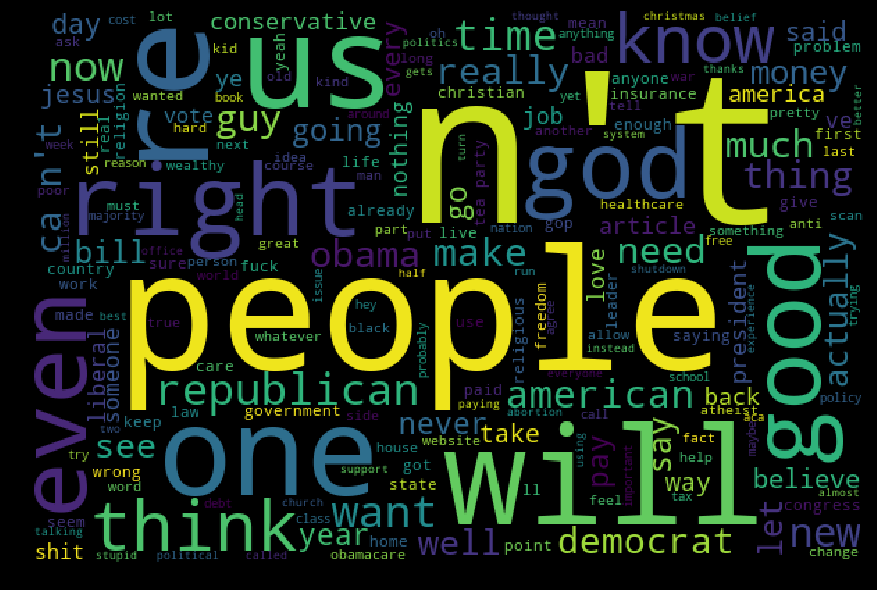

In [15]:
plt.figure( figsize=(12,8), facecolor='k')
plt.imshow(ironic_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

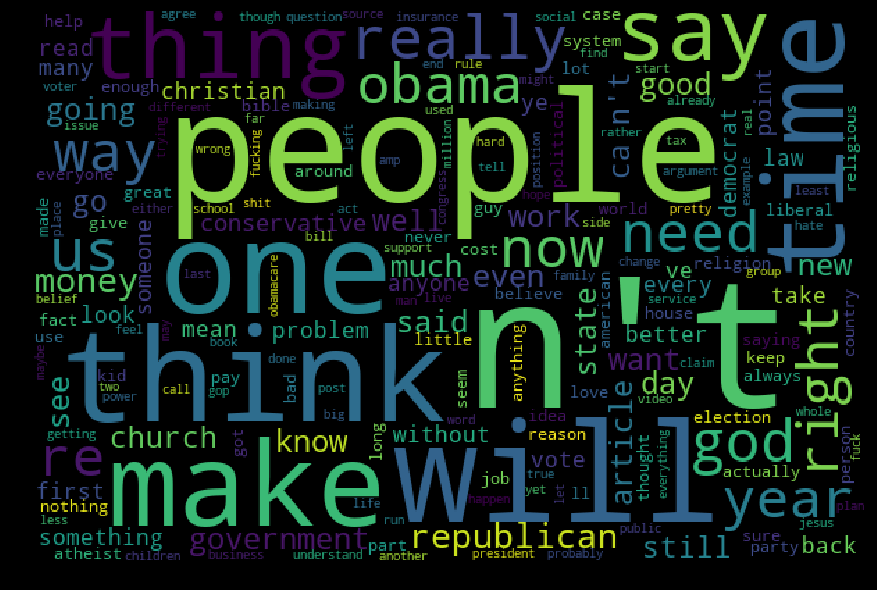

In [16]:
plt.figure( figsize=(12,8), facecolor='k')
plt.imshow(not_ironic_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

# It's visible there's not much difference between two sets, which is not suprising - what makes a sentence ironic is not the literal meaning, which will be the main problem in this analysis.

# Modelling

In [17]:
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.naive_bayes import *
from sklearn.dummy import *
from sklearn.ensemble import *
from sklearn.neighbors import *
from sklearn.tree import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.calibration import *
from sklearn.linear_model import *
from sklearn.multiclass import *
from sklearn.svm import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold,StratifiedKFold
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

### Let's see the scorings without much text processing

In [18]:
def Classification_Vectorization(classifiers, vectorizers, X_train,X_test,y_train,y_test):
    model_scores = []
    for classifier in classifiers:
      for vectorizer in vectorizers:
        
        # train
        vectorize_text = vectorizer.fit_transform(X_train)
        classifier.fit(vectorize_text, y_train)

        # score
        vectorize_text = vectorizer.transform(X_test)
        
        f1score = f1_score(y_test,classifier.predict(vectorize_text))
        
        score = classifier.score(vectorize_text, y_test)
        model_scores.append([classifier.__class__.__name__, vectorizer.__class__.__name__, score,f1score])
        model_scores_df = pd.DataFrame(model_scores, columns=['Classifier','Vectorizer','Score',"F1-Score"])
    return model_scores_df


In [19]:
data_first_run=data.copy()

In [20]:
X_train,X_test,y_train,y_test = train_test_split(data_first_run["comment_text"],data_first_run["label"], \
                                                 test_size = 0.3, random_state = 123)

## 1. First run - without text processing

In [21]:
no_processing=Classification_Vectorization(
    [
        BernoulliNB(),
        RandomForestClassifier(n_estimators=100, n_jobs=-1),
        CalibratedClassifierCV(),
        RidgeClassifierCV(),
        SGDClassifier(),
        KNeighborsClassifier(),
        LogisticRegression(),
        MultinomialNB(),
        SVC(),
        DummyClassifier()
        
    ],
    [
        CountVectorizer(),
        TfidfVectorizer(),
    ],
    X_train,X_test,y_train,y_test
)

/home/karola/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/karola/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [22]:
no_processing.sort_values('F1-Score', ascending = False)

,Classifier,Vectorizer,Score,F1-Score
8,SGDClassifier,CountVectorizer,0.695353,0.400000
9,SGDClassifier,TfidfVectorizer,0.681583,0.307116
18,DummyClassifier,CountVectorizer,0.605852,0.302469
12,LogisticRegression,CountVectorizer,0.685026,0.282353
19,DummyClassifier,TfidfVectorizer,0.595525,0.265823
11,KNeighborsClassifier,TfidfVectorizer,0.700516,0.216216
6,RidgeClassifierCV,CountVectorizer,0.669535,0.179487
14,MultinomialNB,CountVectorizer,0.717728,0.136842
10,KNeighborsClassifier,CountVectorizer,0.671256,0.135747
1,BernoulliNB,TfidfVectorizer,0.717728,0.057471


In [23]:
def ClassificationReport_ConfusionMatrix(classifiers,vectorizers,label_0,label_1,X_train,X_test,y_train,y_test):
    for classifier in classifiers:
        for vectorizer in vectorizers:
            ClassificationReport = ''
            ClassificationReportTitle = ""
            ClassificationReportTitle += classifier.__class__.__name__ + ' with ' + vectorizer.__class__.__name__
            
            vectorize_text = vectorizer.fit_transform(X_train)
            classifier.fit(vectorize_text,y_train)
            vectorize_text = vectorizer.transform(X_test)
            
            ClassificationReport += classification_report(y_test, classifier.predict(vectorize_text),target_names = [label_0,label_1])
            
            conf_mat = confusion_matrix(y_test, classifier.predict(vectorize_text))
        
            print(ClassificationReportTitle)
            print(ClassificationReport)
            print(conf_mat)
            
            conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
            sns.heatmap(conf_mat_normalized)
            plt.ylabel('True label')
            plt.xlabel('Predicted label')
            plt.show()
        

DummyClassifier with CountVectorizer
             precision    recall  f1-score   support

 Not ironic       0.70      0.70      0.70       413
     Ironic       0.27      0.27      0.27       168

avg / total       0.58      0.58      0.58       581

[[293 120]
 [135  33]]


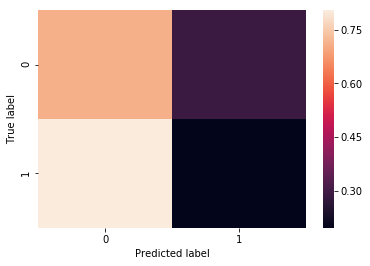

SGDClassifier with CountVectorizer
             precision    recall  f1-score   support

 Not ironic       0.74      0.87      0.80       413
     Ironic       0.43      0.23      0.30       168

avg / total       0.65      0.69      0.66       581

[[361  52]
 [129  39]]


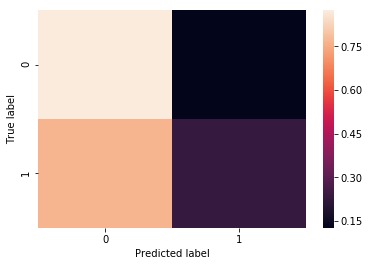

In [24]:
X_train,X_test,y_train,y_test = train_test_split(data_first_run["comment_text"],data_first_run["label"], \
                                                 test_size = 0.3, random_state = 123)

ClassificationReport_ConfusionMatrix([DummyClassifier(),SGDClassifier()],     
        [CountVectorizer()],
    "Not ironic","Ironic",X_train,X_test,y_train,y_test)

### SGDClassifier with CountVectorizer has the highest F1 score on Ironic statements. I'll see if text processing improves the score.

## 2. Removing punctuation, stop words

In [25]:
def text_process(text):
    
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    
    return " ".join(text)

In [26]:
data_processed_1=data_first_run.copy()
data_processed_1["comment_text"] = data_processed_1["comment_text"].apply(text_process)

In [27]:
data_processed_1.head()

,comment_text,label
0,suspect atheists projecting desires imagine Obama one number anyone remember crazy preacher associated examiner understand career politician USA needing feign belief get elected purpose Id imagine vanilla choice church Hes atheist Hes liberal either,0
1,funny arguments shills making still close racist remarks GOP already admitted Always attacking lazy minorities young people “if hurts bunch college kids that’s lazy get bohunkus sic get photo ID it” “if hurts bunch lazy blacks wants government give everything ” “the law going kick Democrats butt ”,0
2,truly following patterns mandarins took empires sword control endless paper regulations stagnate peoples lives anything productive dont see else write even laws regulations either nothing hinder freedom production,0
3,air pressure dropping altitude goes higher Less pressure around exhaust stream high pressure expands wider go higherIf look video exhaust stream far wider craft,0
4,Absolutely think wed hard pressed find website didnt experience sort slowdown getting 2 6 million 5 million visits 18 hours Also bound glitches rolling program scope,0


In [28]:
# I'm using random_state = 123, the same seed as in the previous train, test split

X_train,X_test,y_train,y_test = train_test_split(data_processed_1["comment_text"],data_processed_1["label"], \
                                                 test_size = 0.3, random_state = 123)

In [29]:
stopwords_punctuation=Classification_Vectorization(
    [
        BernoulliNB(),
        RandomForestClassifier(n_estimators=100, n_jobs=-1),
        CalibratedClassifierCV(),
        RidgeClassifierCV(),
        SGDClassifier(),
        KNeighborsClassifier(),
        LogisticRegression(),
        MultinomialNB(),
        SVC(),
        DummyClassifier()
        
    ],
    [
        CountVectorizer(),
        TfidfVectorizer(),
    ],
    X_train,X_test,y_train,y_test
)

/home/karola/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/karola/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [30]:
results = pd.merge(no_processing,stopwords_punctuation[['Score',"F1-Score"]],left_index=True, right_index=True,\
                   how='left', suffixes=('_first', '_second'))

In [31]:
results.sort_values('F1-Score_second', ascending = False)

,Classifier,Vectorizer,Score_first,F1-Score_first,Score_second,F1-Score_second
8,SGDClassifier,CountVectorizer,0.695353,0.400000,0.660929,0.390093
18,DummyClassifier,CountVectorizer,0.605852,0.302469,0.612737,0.293255
9,SGDClassifier,TfidfVectorizer,0.681583,0.307116,0.681583,0.280156
19,DummyClassifier,TfidfVectorizer,0.595525,0.265823,0.586919,0.242424
14,MultinomialNB,CountVectorizer,0.717728,0.136842,0.710843,0.184466
12,LogisticRegression,CountVectorizer,0.685026,0.282353,0.667814,0.171674
6,RidgeClassifierCV,CountVectorizer,0.669535,0.179487,0.683305,0.115385
3,RandomForestClassifier,TfidfVectorizer,0.714286,0.034884,0.710843,0.086957
2,RandomForestClassifier,CountVectorizer,0.712565,0.011834,0.691910,0.072539
10,KNeighborsClassifier,CountVectorizer,0.671256,0.135747,0.690189,0.042553


### it didn't improve significantly the results

DummyClassifier with CountVectorizer
             precision    recall  f1-score   support

 Not ironic       0.69      0.69      0.69       413
     Ironic       0.25      0.26      0.25       168

avg / total       0.57      0.56      0.56       581

[[300 113]
 [103  65]]


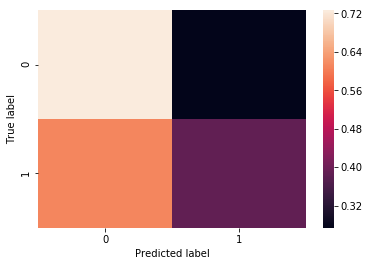

SGDClassifier with CountVectorizer
             precision    recall  f1-score   support

 Not ironic       0.74      0.77      0.75       413
     Ironic       0.37      0.33      0.35       168

avg / total       0.63      0.64      0.64       581

[[318  95]
 [112  56]]


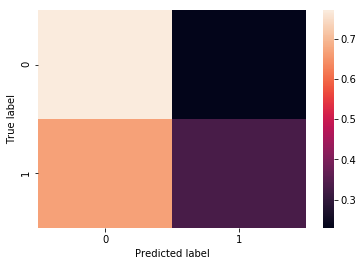

In [32]:
X_train,X_test,y_train,y_test = train_test_split(data_processed_1["comment_text"],data_processed_1["label"], \
                                                 test_size = 0.3, random_state = 123)

ClassificationReport_ConfusionMatrix([DummyClassifier(),SGDClassifier()],
                                     [CountVectorizer()],
                                     "Not ironic","Ironic",X_train,X_test,y_train,y_test)

## 3. Stemmer

In [33]:
def stemmer (text):
    text = text.split()
    words = ""
    for i in text:
            stemmer = SnowballStemmer("english")
            words += (stemmer.stem(i))+" "
    return words

In [34]:
data_processed_2=data_processed_1.copy()
data_processed_2["comment_text"] = data_processed_2["comment_text"].apply(stemmer)
data_processed_2.head()

,comment_text,label
0,suspect atheist project desir imagin obama one number anyon rememb crazi preacher associ examin understand career politician usa need feign belief get elect purpos id imagin vanilla choic church hes atheist hes liber either,0
1,funni argument shill make still close racist remark gop alreadi admit alway attack lazi minor young peopl “if hurt bunch colleg kid that lazi get bohunkus sic get photo id it” “if hurt bunch lazi black want govern give everyth ” “the law go kick democrat butt ”,0
2,truli follow pattern mandarin took empir sword control endless paper regul stagnat peopl live anyth product dont see els write even law regul either noth hinder freedom product,0
3,air pressur drop altitud goe higher less pressur around exhaust stream high pressur expand wider go higherif look video exhaust stream far wider craft,0
4,absolut think wed hard press find websit didnt experi sort slowdown get 2 6 million 5 million visit 18 hour also bound glitch roll program scope,0


In [35]:
X_train,X_test,y_train,y_test = train_test_split(data_processed_2["comment_text"],data_processed_2["label"], \
                                                 test_size = 0.3, random_state = 123)

In [36]:
stemmer=Classification_Vectorization(
    [
        BernoulliNB(),
        RandomForestClassifier(n_estimators=100, n_jobs=-1),
        CalibratedClassifierCV(),
        RidgeClassifierCV(),
        SGDClassifier(),
        KNeighborsClassifier(),
        LogisticRegression(),
        MultinomialNB(),
        SVC(),
        DummyClassifier()
        
    ],
    [
        CountVectorizer(),
        TfidfVectorizer(),
    ],
    X_train,X_test,y_train,y_test
)

/home/karola/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [37]:
results = pd.merge(results,stemmer[['Score',"F1-Score"]],left_index=True, right_index=True,\
                   how='left')


In [38]:
results.rename(columns = {'Score':'Score_third', 'F1-Score':'F1-Score_third'}, inplace = True)

In [39]:
results.sort_values('F1-Score_third', ascending = False)

,Classifier,Vectorizer,Score_first,F1-Score_first,Score_second,F1-Score_second,Score_third,F1-Score_third
8,SGDClassifier,CountVectorizer,0.695353,0.400000,0.660929,0.390093,0.631670,0.359281
18,DummyClassifier,CountVectorizer,0.605852,0.302469,0.612737,0.293255,0.590361,0.347059
9,SGDClassifier,TfidfVectorizer,0.681583,0.307116,0.681583,0.280156,0.666093,0.316901
12,LogisticRegression,CountVectorizer,0.685026,0.282353,0.667814,0.171674,0.672978,0.246032
14,MultinomialNB,CountVectorizer,0.717728,0.136842,0.710843,0.184466,0.714286,0.238532
19,DummyClassifier,TfidfVectorizer,0.595525,0.265823,0.586919,0.242424,0.626506,0.236760
6,RidgeClassifierCV,CountVectorizer,0.669535,0.179487,0.683305,0.115385,0.678141,0.130233
2,RandomForestClassifier,CountVectorizer,0.712565,0.011834,0.691910,0.072539,0.702238,0.121827
3,RandomForestClassifier,TfidfVectorizer,0.714286,0.034884,0.710843,0.086957,0.697074,0.073684
10,KNeighborsClassifier,CountVectorizer,0.671256,0.135747,0.690189,0.042553,0.690189,0.062500


### I'll use GridSearchCV to find the best parameters and choose one and the best model based on processed data.

In [40]:
X_train,X_test,y_train,y_test = train_test_split(data_processed_2["comment_text"],data_processed_2["label"], \
                                                 test_size = 0.3, random_state = 123)


vectorizer = CountVectorizer()
vectorizer.fit(X_train)
X_train= vectorizer.transform(X_train)
X_test= vectorizer.transform(X_test)
prediction = dict()

pipes = {
    
    "SGDClassifier":Pipeline([
    ("SGDClassifier",SGDClassifier())]),
    
    "MultinomialNB":Pipeline([
    ("MultinomialNB",MultinomialNB())]),
    
    "LogisticRegression":Pipeline([
        ("LogisticRegression",LogisticRegression())]),

}

param_grids = {
    
    
    "MultinomialNB":{
              "MultinomialNB__alpha":[1.0,10.0,0.5]
    },
    
    "LogisticRegression":{'LogisticRegression__C':[0.1,0.3,0.5,1,1.5,2],
          'LogisticRegression__penalty':["l1","l2"],
    },
    
     "SGDClassifier":{'SGDClassifier__loss':["hinge","log","modified_huber","perceptron","squared_hinge"],
                      'SGDClassifier__penalty':["l2","l1","elasticnet"],
                      
    }
}


steps = [pipes, param_grids]
results = {}

for key in steps[0]:
    pipe = steps[0][key]
    param_grid = steps[1][key]
    gs = GridSearchCV(pipe, param_grid, cv=StratifiedKFold(10, shuffle=True),scoring='accuracy',n_jobs=-1)
    gs.fit(X_train,y_train)
    
    score = accuracy_score(y_test,gs.best_estimator_.predict(X_test))
    best_params = gs.best_params_
    best_score = gs.best_score_
    results[key] = {"prediction accuracy score":score,"best params":best_params,"train score":best_score}

In [41]:
results

{'LogisticRegression': {'best params': {'LogisticRegression__C': 0.1,
   'LogisticRegression__penalty': 'l1'},
  'prediction accuracy score': 0.71084337349397586,
  'train score': 0.72727272727272729},
 'MultinomialNB': {'best params': {'MultinomialNB__alpha': 10.0},
  'prediction accuracy score': 0.7091222030981067,
  'train score': 0.72653362897265339},
 'SGDClassifier': {'best params': {'SGDClassifier__loss': 'perceptron',
   'SGDClassifier__penalty': 'l2'},
  'prediction accuracy score': 0.65232358003442337,
  'train score': 0.67036215816703626}}

## Confusion matrix, classification report - comparison between SGDClassifier, MultinomialNB and Logistic Regression

DummyClassifier with CountVectorizer
             precision    recall  f1-score   support

 Not ironic       0.71      0.74      0.73       413
     Ironic       0.29      0.26      0.28       168

avg / total       0.59      0.60      0.60       581

[[316  97]
 [123  45]]


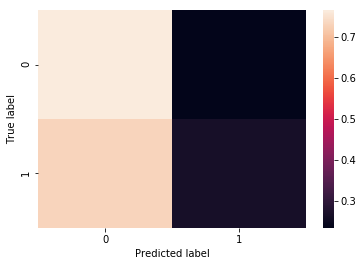

LogisticRegression with CountVectorizer
             precision    recall  f1-score   support

 Not ironic       0.71      1.00      0.83       413
     Ironic       0.00      0.00      0.00       168

avg / total       0.51      0.71      0.59       581

[[413   0]
 [168   0]]


/home/karola/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


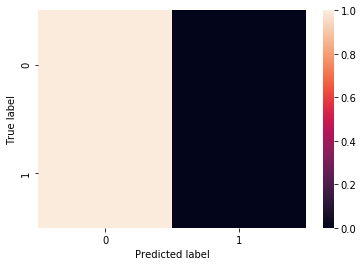

MultinomialNB with CountVectorizer
             precision    recall  f1-score   support

 Not ironic       0.71      1.00      0.83       413
     Ironic       0.00      0.00      0.00       168

avg / total       0.50      0.71      0.59       581

[[412   1]
 [168   0]]


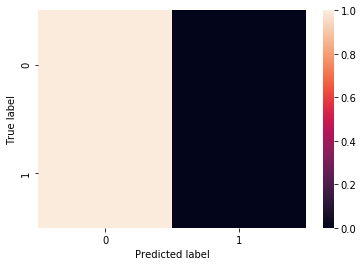

SGDClassifier with CountVectorizer
             precision    recall  f1-score   support

 Not ironic       0.74      0.75      0.74       413
     Ironic       0.36      0.35      0.35       168

avg / total       0.63      0.63      0.63       581

[[310 103]
 [110  58]]


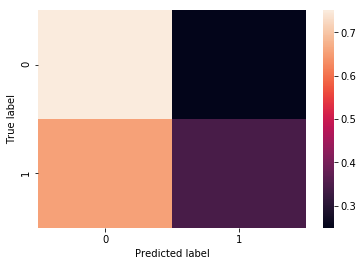

In [42]:
X_train,X_test,y_train,y_test = train_test_split(data_processed_2["comment_text"],data_processed_2["label"], \
                                                 test_size = 0.3, random_state = 123)

ClassificationReport_ConfusionMatrix([DummyClassifier(),LogisticRegression(C=0.1,penalty="l1"),MultinomialNB(alpha=10),
                                      SGDClassifier(loss='hinge',penalty="l2")],
                                     [CountVectorizer()],
                                     "Not ironic","Ironic",X_train,X_test,y_train,y_test)

SGDClassifier with CountVectorizer
             precision    recall  f1-score   support

 Not ironic       0.74      0.91      0.81       413
     Ironic       0.48      0.21      0.30       168

avg / total       0.66      0.71      0.66       581

[[374  39]
 [132  36]]


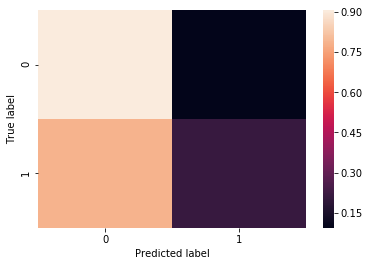

In [43]:
# To compare the results with no processed data and default CountVectorizer parameters:

X_train,X_test,y_train,y_test = train_test_split(data_first_run["comment_text"],data_first_run["label"], \
                                                 test_size = 0.3, random_state = 123)

ClassificationReport_ConfusionMatrix([SGDClassifier()],     
        [CountVectorizer()],
    "Not ironic","Ironic",X_train,X_test,y_train,y_test)

### I'll see if changing the parameters of CountVectorizer changes anything

In [44]:
X_train,X_test,y_train,y_test = train_test_split(data_processed_2["comment_text"],data_processed_2["label"], \
                                                 test_size = 0.3, random_state = 123)

pipeline = Pipeline([
    ('CountVectorizer', CountVectorizer()),
    ('SGDClassifier', SGDClassifier()),
])
parameters = {
    'CountVectorizer__max_df': (0.25, 0.5, 0.75),
    'CountVectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'SGDClassifier__loss':["hinge","log","modified_huber","perceptron","squared_hinge"],
    'SGDClassifier__penalty':["l2","l1","elasticnet"]
    
}


grid_search_tune = GridSearchCV(pipeline, parameters, cv=2, n_jobs=2,verbose=1)
grid_search_tune.fit(X_train, y_train)
score_best = accuracy_score(y_test,grid_search_tune.best_estimator_.predict(X_test))
best_params = grid_search_tune.best_params_



Fitting 2 folds for each of 135 candidates, totalling 270 fits


[Parallel(n_jobs=2)]: Done 178 tasks      | elapsed:   11.7s
[Parallel(n_jobs=2)]: Done 267 out of 270 | elapsed:   17.3s remaining:    0.2s
[Parallel(n_jobs=2)]: Done 270 out of 270 | elapsed:   17.3s finished


In [45]:
print(best_params , score_best)

{'CountVectorizer__max_df': 0.25, 'CountVectorizer__ngram_range': (1, 3), 'SGDClassifier__loss': 'hinge', 'SGDClassifier__penalty': 'l2'} 0.685025817556


SGDClassifier with CountVectorizer
             precision    recall  f1-score   support

 Not ironic       0.73      0.86      0.79       413
     Ironic       0.40      0.24      0.30       168

avg / total       0.64      0.68      0.65       581

[[354  59]
 [128  40]]


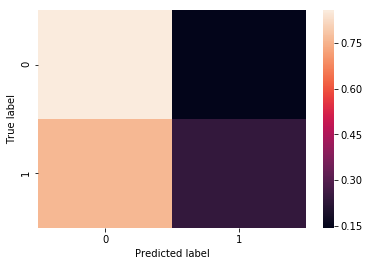

In [46]:
ClassificationReport_ConfusionMatrix([SGDClassifier(loss = 'squared_hinge',penalty = "l2")],     
        [CountVectorizer(max_df = 0.75, ngram_range = (1, 2))],
    "Not ironic","Ironic",X_train,X_test,y_train,y_test)

SGDClassifier with CountVectorizer
             precision    recall  f1-score   support

 Not ironic       0.75      0.79      0.77       413
     Ironic       0.41      0.35      0.37       168

avg / total       0.65      0.66      0.66       581

[[328  85]
 [110  58]]


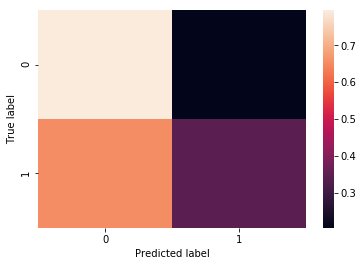

In [47]:
# To compare the results with no processed data and default CountVectorizer parameters:

X_train,X_test,y_train,y_test = train_test_split(data_first_run["comment_text"],data_first_run["label"], \
                                                 test_size = 0.3, random_state = 123)

ClassificationReport_ConfusionMatrix([SGDClassifier()],     
        [CountVectorizer()],
    "Not ironic","Ironic",X_train,X_test,y_train,y_test)

# As expected the satisfactory results are very hard to reach. The best model in this case was SGD Classifier. Unfortunately text processing did not significantly improve the results.